In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('sb_30-05_slim_slim-1.csv')

In [3]:
sb_labs = df['shot_statsbomb_xg'].values
y = df['goal'].values

print(f"sb_labs shape: {sb_labs.shape}, y shape: {y.shape}")

sb_labs shape: (77617,), y shape: (77617,)


In [4]:
df.drop(['shot_body_part', 'shot_technique', 'shot_outcome', 'goal', 'shot_statsbomb_xg'], axis = 1, inplace = True)

In [5]:
df_1h = pd.get_dummies(df, columns = ['play_pattern', 'shot_aerial_won', 'shot_first_time', 
                                      'shot_one_on_one', 'shot_type', 'under_pressure', 'prev_type'])

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, sb_train, sb_test = train_test_split(
    df_1h, y, sb_labs, random_state=42)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

In [8]:
input_size = X_train.shape[1]  # Number of features
hidden_size = 500
num_classes = 1  # Binary classification


model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, num_classes),
    nn.Sigmoid()  # Sigmoid activation for binary classification
).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()  # Binary cross-entropy loss

In [9]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Forward pass
        output = model(data).squeeze()  # Squeeze to match the target shape
        loss = criterion(output, target)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test(epoch):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data).squeeze()
            predicted = (output > 0.5).float()  # Apply threshold for binary classification
            correct += (predicted == target).sum().item()
            total += target.size(0)
    accuracy = 100 * correct / total
    print(f'Test accuracy after {epoch+1} epochs: {accuracy:.2f} %')


In [10]:
num_epochs = 10
for epoch in range(num_epochs):
    train(epoch)
    test(epoch)

# Save the trained model
torch.save(model.state_dict(), 'binary_classification_model.pth')


Train Epoch: 1 [9900/58212 (17%)]	Loss: 0.251854
Train Epoch: 1 [19900/58212 (34%)]	Loss: 0.322240
Train Epoch: 1 [29900/58212 (51%)]	Loss: 0.292350
Train Epoch: 1 [39900/58212 (68%)]	Loss: 0.352633
Train Epoch: 1 [49900/58212 (86%)]	Loss: 0.270714
Test accuracy after 1 epochs: 90.61 %
Train Epoch: 2 [9900/58212 (17%)]	Loss: 0.273825
Train Epoch: 2 [19900/58212 (34%)]	Loss: 0.229251
Train Epoch: 2 [29900/58212 (51%)]	Loss: 0.251601
Train Epoch: 2 [39900/58212 (68%)]	Loss: 0.430056
Train Epoch: 2 [49900/58212 (86%)]	Loss: 0.282198
Test accuracy after 2 epochs: 90.70 %
Train Epoch: 3 [9900/58212 (17%)]	Loss: 0.240802
Train Epoch: 3 [19900/58212 (34%)]	Loss: 0.296922
Train Epoch: 3 [29900/58212 (51%)]	Loss: 0.136101
Train Epoch: 3 [39900/58212 (68%)]	Loss: 0.222429
Train Epoch: 3 [49900/58212 (86%)]	Loss: 0.216744
Test accuracy after 3 epochs: 90.82 %
Train Epoch: 4 [9900/58212 (17%)]	Loss: 0.184129
Train Epoch: 4 [19900/58212 (34%)]	Loss: 0.200029
Train Epoch: 4 [29900/58212 (51%)]	Loss:

In [12]:
model.eval()
with torch.no_grad():
    output = model(X_test_tensor.to(device)).squeeze()
    y_pred_probs = output.cpu().numpy()



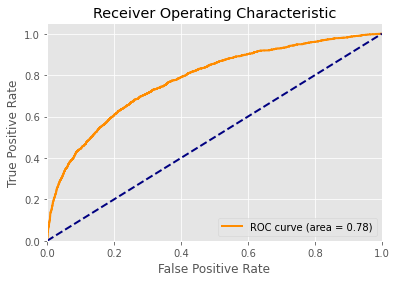

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
plt.style.use('ggplot')
y_test_conv = y_test.astype(int)
roc_auc = roc_auc_score(y_test_conv, y_pred_probs)

fpr, tpr, _ = roc_curve(y_test_conv, y_pred_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

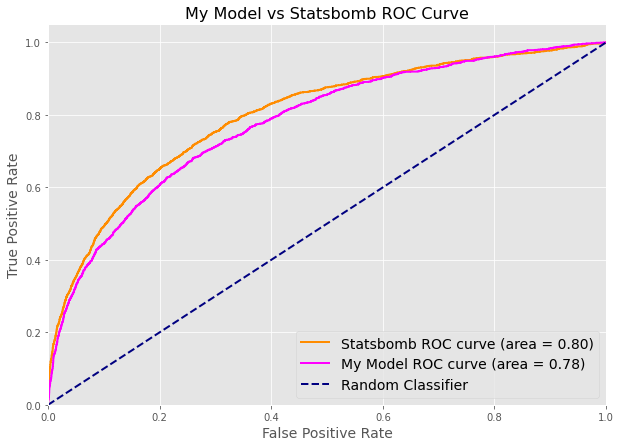

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
plt.style.use('ggplot')


roc_auc_sb = roc_auc_score(y_test_conv, sb_test)

fpr_sb, tpr_sb, _ = roc_curve(y_test_conv, sb_test)
plt.figure(figsize = (10,7))
plt.plot(fpr_sb, tpr_sb, color='darkorange', lw=2, label=f'Statsbomb ROC curve (area = {roc_auc_sb:.2f})')
plt.plot(fpr, tpr, color='#FF00FF', lw=2, label=f'My Model ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('My Model vs Statsbomb ROC Curve', fontsize = 16)
plt.legend(loc='lower right', fontsize = 14)
#plt.savefig('first_attempt1.png', dpi = 1000, facecolor = 'white', bbox_inches = 'tight')
plt.show()

In [18]:
from sklearn.metrics import log_loss

logloss_model = log_loss(y_test_conv, y_pred_probs)
logloss_sb = log_loss(y_test_conv, sb_test)

print(f"Model Log Loss: {logloss_model}")
print(f"Statsbomb Log Loss: {logloss_sb}")

Model Log Loss: 0.2661619977421897
Statsbomb Log Loss: 0.25385731116418275
